## Connect to the PostgresSQL Database
I have written a python script in scripts/load file to connect to the PostgresSQL db, extract the required tables, and load them into Pandas DataFrames. 

In `load.py` file, I have SQLAlchemy and Python-PostgreSQL connectors to perform queries. But for now, I have used Python-PostgreSQL connectors to do so.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../scripts'))
from db_connection import load_data_from_postgres, load_data_using_sqlalchemy
sys.path.append(os.path.abspath('../src'))

from utils import missing_values_table, convert_bytes_to_megabytes, \
    visualize_missing_values, replace_missing_values, detect_outliers_zscore,\
    remove_outliers

from user_analysis_utils import top_10_handsets, top_3_manufacturers, \
    top_5_handsets_per_manufacturer, aggregate_user_data

from graphical_analysis import graphical_univariate_analysis, bivariate_analysis\
    ,correlation_analysis, perform_pca

In [2]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


/home/seife/Desktop/Kifiya_AIM/Telecom-User-Analytics/scripts/db_connection.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [4]:
df.shape

(150001, 55)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

### Initial Data Exploration

* Check for missing values and outliers in the dataset. For this I have a script written to clean the data (impute missing values with the median, handle outliers).

In [6]:
# The dataframe with missing information
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.

Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)      

<Axes: >

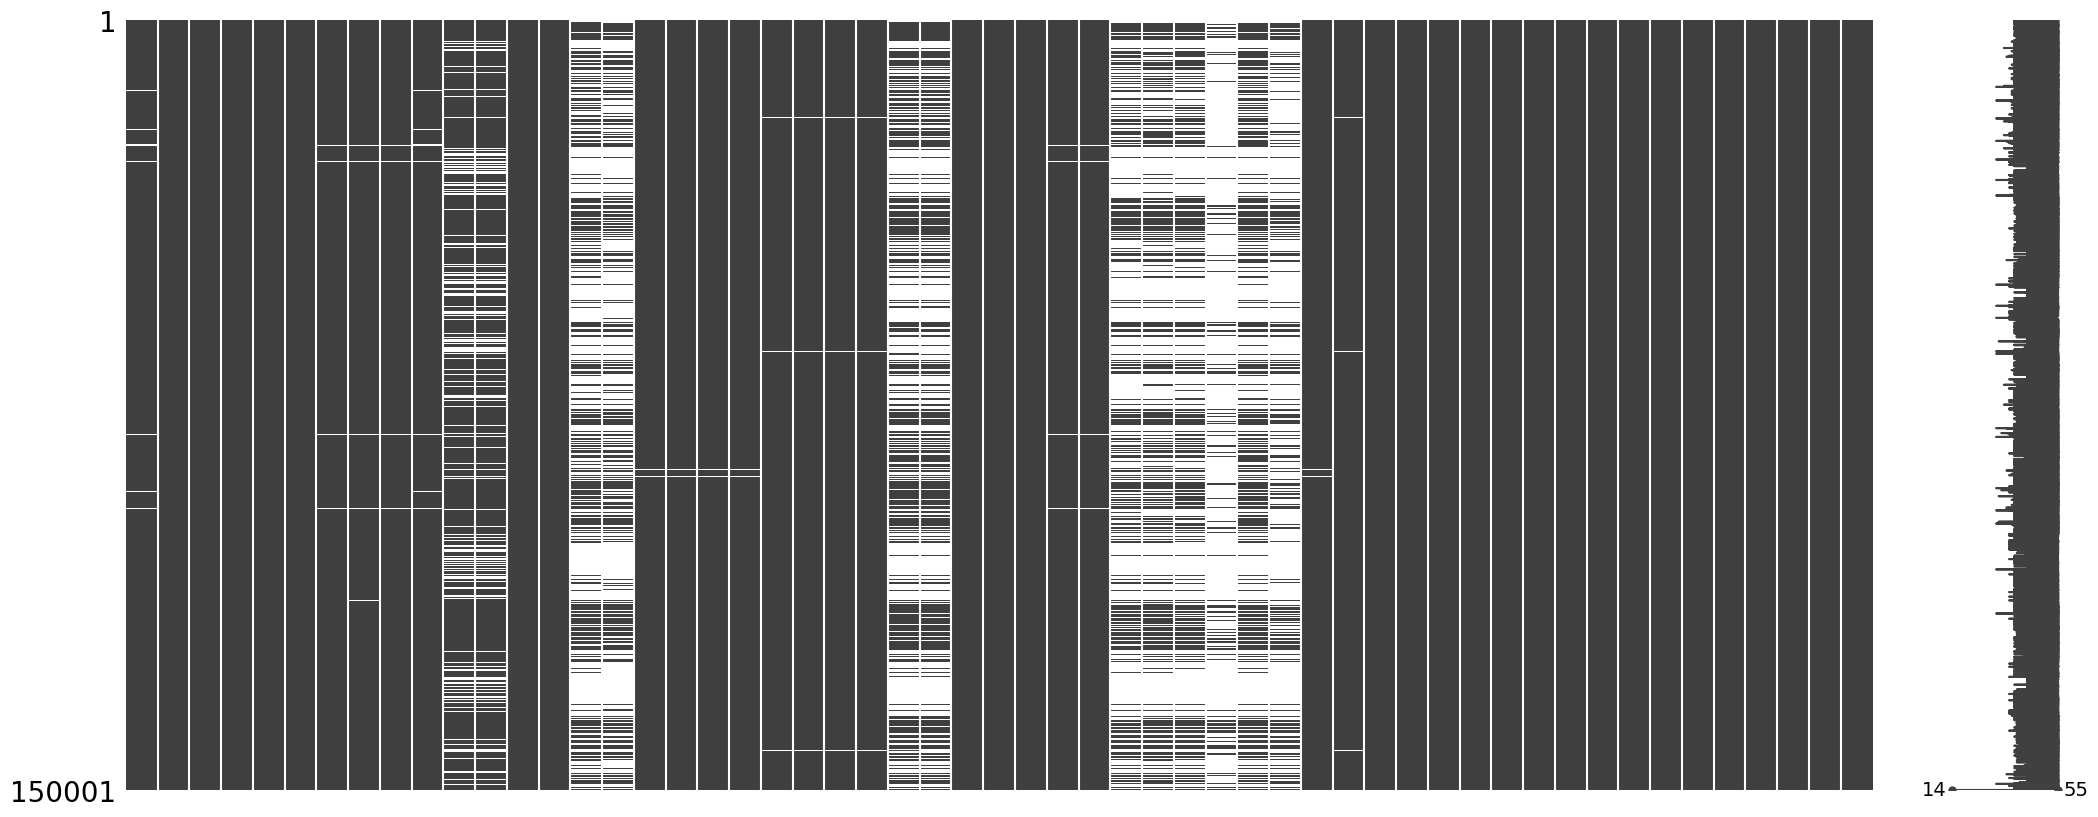

In [7]:
# Visualize missing values
visualize_missing_values(df)

Missing numerical columns: ['Bearer Id', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Total UL (Bytes)', 'Total DL (Bytes)']
Missing categorical columns: ['Start', 'End', 'Last Loca

<Axes: >

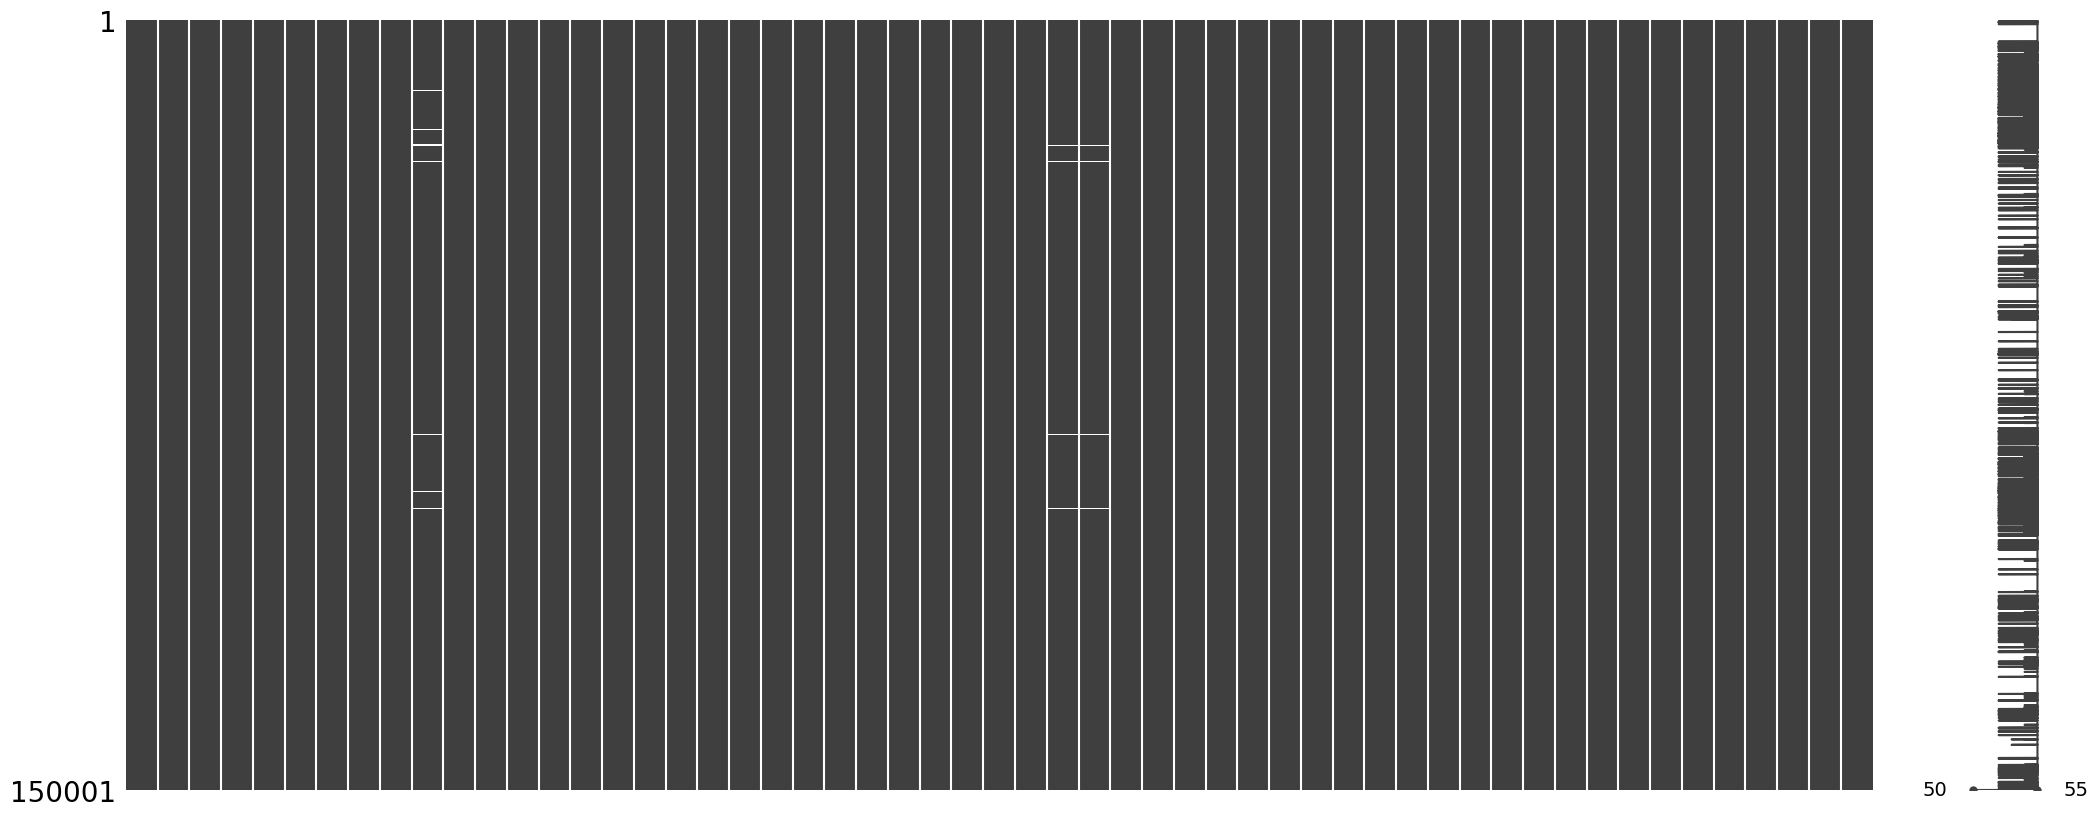

In [8]:
# Replace missing values by median
replace_missing_values(df)

In [9]:
df['x'] = convert_bytes_to_megabytes(df, 'HTTP DL (Bytes)')

**Check for outlier in datasets**

In [10]:
# Storing column names as a list
column_names = df.select_dtypes(exclude=['object']).columns.tolist()

for column in column_names:
    # Check for outliers
    outliers = detect_outliers_zscore(df, column)
    if len(outliers) > 0:
        print(f"Outliers detected in column {column}. Length: {len(outliers)}")
        # Remove outliers
        df = remove_outliers(df, column)

Outliers detected in column Dur. (ms). Length: 2214
Outliers detected in column IMSI. Length: 2
Outliers detected in column MSISDN/Number. Length: 1
Outliers detected in column Avg RTT DL (ms). Length: 809
Outliers detected in column Avg RTT UL (ms). Length: 729
Outliers detected in column Avg Bearer TP DL (kbps). Length: 2898
Outliers detected in column Avg Bearer TP UL (kbps). Length: 4097
Outliers detected in column TCP DL Retrans. Vol (Bytes). Length: 424
Outliers detected in column TCP UL Retrans. Vol (Bytes). Length: 58
Outliers detected in column DL TP < 50 Kbps (%). Length: 3752
Outliers detected in column 50 Kbps < DL TP < 250 Kbps (%). Length: 3680
Outliers detected in column 250 Kbps < DL TP < 1 Mbps (%). Length: 3307
Outliers detected in column DL TP > 1 Mbps (%). Length: 2857
Outliers detected in column UL TP < 10 Kbps (%). Length: 1261
Outliers detected in column 10 Kbps < UL TP < 50 Kbps (%). Length: 3993
Outliers detected in column 50 Kbps < UL TP < 300 Kbps (%). Length

Now, I would like to check **duplicate** columns and rows

In [11]:
#rows
duplicated_rows = df[df.duplicated()]
if len(duplicated_rows) > 0:
    print(f"Duplicate rows found: {len(duplicated_rows)}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [12]:
# columns
duplicated_columns = df.columns[df.columns.duplicated()]
if len(duplicated_columns) > 0:
    print(f"Duplicate columns found: {', '.join(duplicated_columns)}")
else:
    print("No duplicate columns found.")

No duplicate columns found.


In [13]:
# Display summary statistics for numeric columns
print(df.describe())

          Bearer Id      Start ms        End ms      Dur. (ms)          IMSI  \
count  9.643700e+04  96437.000000  96437.000000   96437.000000  9.643700e+04   
mean   9.963656e+18    499.379958    498.554061  107314.417018  2.082017e+14   
std    2.883384e+18    288.163265    287.818713   60947.621362  1.401239e+09   
min    6.917538e+18      0.000000      0.000000    7142.000000  2.082001e+14   
25%    7.349883e+18    251.000000    252.000000   60623.000000  2.082010e+14   
50%    7.349883e+18    499.000000    499.000000   97513.000000  2.082015e+14   
75%    1.311448e+19    748.000000    750.000000  148332.000000  2.082018e+14   
max    1.318654e+19    999.000000    999.000000  297890.000000  2.082099e+14   

       MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count   9.643700e+04  9.643700e+04     96437.000000     96437.000000   
mean    3.367274e+10  4.188719e+13        60.501270         6.001369   
std     4.557751e+07  1.725898e+13       112.596307        11.6

The above **descriptive statistics** provide various insights into the usage patterns of different services by telecom users. Looking at different services such as *Netflix*, *YouTube*, and *gaming*, while also accounting for the *total traffic*. It shows how much data was consumed, the duration of sessions, and the network latency (RTT) across multiple users.

The percentiles give insight into how usage is distributed among users, while standard deviation shows how spread out the data usage is from the mean.

The telecom dataset shows significant usage of **data-driven** services such as streaming (Netflix and YouTube) and gaming, with wide variation among users in terms of both data consumption and session durations. While the network appears to handle traffic with relatively low latency, the high standard deviations point to diverse user behaviors.

### **User Analysis**

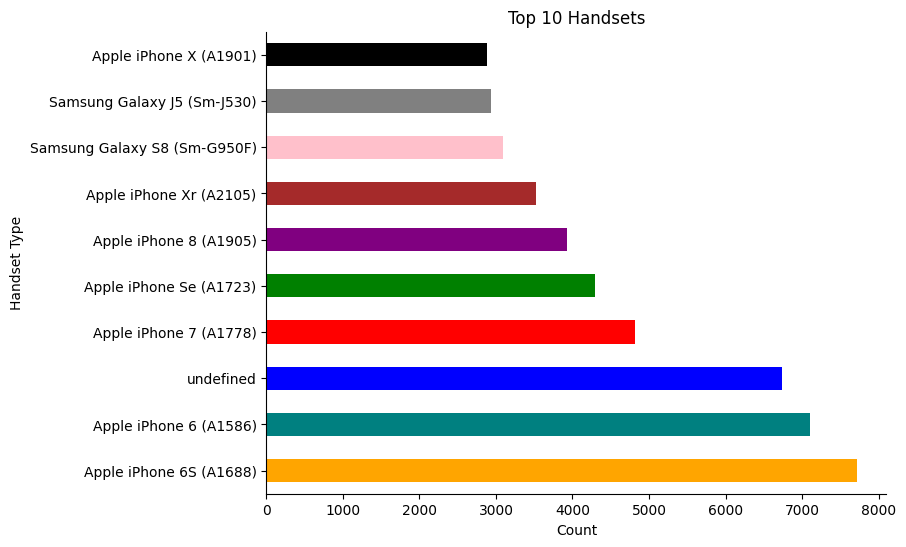

In [14]:
top_10_handsets_df = top_10_handsets(df)

# Plot the top 10 handsets
top_10_handsets_df.plot(
    kind='barh',
    title='Top 10 Handsets',
    color=['orange', 'teal', 'blue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'black'],
    figsize=(8, 6)
)

# Remove top and right spines from the plot for cleaner visualization
plt.gca().spines[['top', 'right']].set_visible(False)

# Display the plot
plt.xlabel('Count')
plt.ylabel('Handset Type')
plt.show()

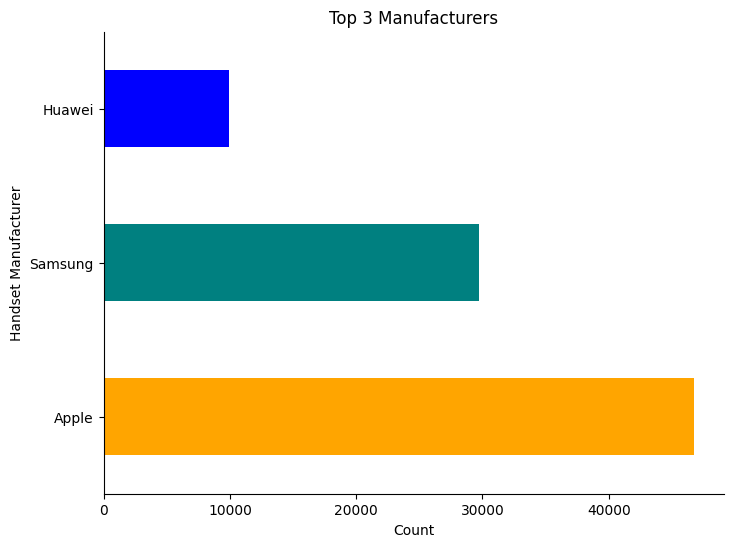

In [15]:
top_3_manufacturers_df = top_3_manufacturers(df)

# Plot the top 3 manufacturers
top_3_manufacturers_df.plot(
    kind='barh',
    x='Handset Manufacturer',
    y='Count',
    title='Top 3 Manufacturers',
    color=['orange', 'teal', 'blue'],
    figsize=(8, 6)
)

# Remove top and right spines from the plot for cleaner visualization
plt.gca().spines[['top', 'right']].set_visible(False)

# Display the plot
plt.xlabel('Count')
plt.ylabel('Handset Manufacturer')
plt.show()

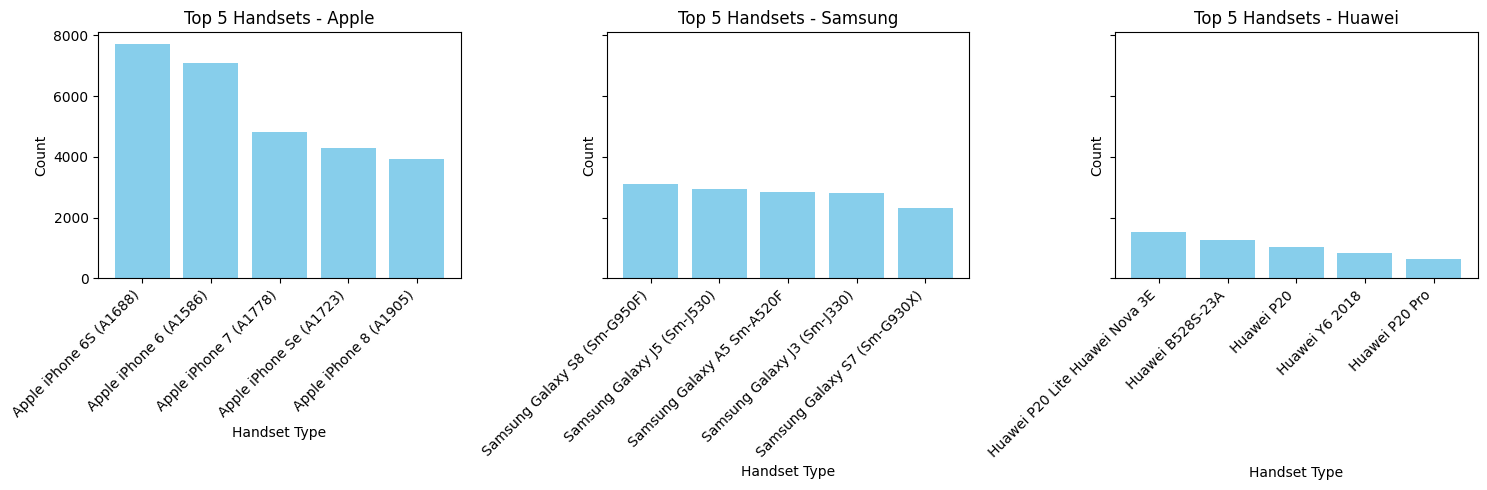

In [16]:
# Get top 5 handsets per manufacturer
top_5_handsets_per_manufacturer_df = top_5_handsets_per_manufacturer(df, top_3_manufacturers_df)

# Create a subplot with number of manufacturers
num_manufacturers = len(top_5_handsets_per_manufacturer_df)

# Define the figure size based on the number of manufacturers
fig, axes = plt.subplots(nrows=1, ncols=num_manufacturers, figsize=(15, 5), sharey=True)

# If only one manufacturer is present, wrap the axes in a list for consistency
if num_manufacturers == 1:
    axes = [axes]

# Iterate over each manufacturer and create a bar plot for each
for ax, (manufacturer, handsets) in zip(axes, top_5_handsets_per_manufacturer_df.items()):
    ax.bar(handsets.index, handsets.values, color='skyblue')
    ax.set_title(f"Top 5 Handsets - {manufacturer}")
    ax.set_xlabel("Handset Type")
    ax.set_ylabel("Count")
    ax.set_xticks(range(len(handsets.index)))
    ax.set_xticklabels(handsets.index, rotation=45, ha='right')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

### User Behavior on Application

In [17]:
# Displaying the aggregated data
aggregated_data = aggregate_user_data(df)
aggregated_data.head(10)

,MSISDN/Number,session_count,total_duration_ms,total_download,total_upload,Social Media_total_data,Google_total_data,Email_total_data,Youtube_total_data,Netflix_total_data,Gaming_total_data,Other_total_data
0,3.360100e+10,1,116720.0,842637466.0,36053108.0,386570872.0,386570872.0,386570872.0,386570872.0,386570872.0,386570872.0,386570872.0
1,3.360100e+10,1,181230.0,120755184.0,36104459.0,281710071.0,281710071.0,281710071.0,281710071.0,281710071.0,281710071.0,281710071.0
2,3.360100e+10,1,134969.0,556659663.0,39306820.0,501693672.0,501693672.0,501693672.0,501693672.0,501693672.0,501693672.0,501693672.0
3,3.360101e+10,1,49878.0,401993172.0,20327526.0,35279702.0,35279702.0,35279702.0,35279702.0,35279702.0,35279702.0,35279702.0
4,3.360101e+10,1,18549.0,547096937.0,38481427.0,718815824.0,718815824.0,718815824.0,718815824.0,718815824.0,718815824.0,718815824.0
5,3.360101e+10,2,253983.0,555207972.0,60009249.0,492372777.0,492372777.0,492372777.0,492372777.0,492372777.0,492372777.0,492372777.0
6,3.360101e+10,1,64180.0,381330543.0,74341532.0,208427543.0,208427543.0,208427543.0,208427543.0,208427543.0,208427543.0,208427543.0
7,3.360101e+10,1,86399.0,294085078.0,38575279.0,178201537.0,178201537.0,178201537.0,178201537.0,178201537.0,178201537.0,178201537.0
8,3.360101e+10,1,155850.0,286940304.0,57829553.0,463017134.0,463017134.0,463017134.0,463017134.0,463017134.0,463017134.0,463017134.0
9,3.360102e+10,1,124854.0,685372753.0,47091008.0,138339248.0,138339248.0,138339248.0,138339248.0,138339248.0,138339248.0,138339248.0


As we have seen in the table above, the data represents user behavior related to application-specific data usage, aggregated by user sessions. Each user, identified by their MSISDN/Number, has metrics such as the total number of sessions (session_count), total duration of activity in milliseconds (total_duration_ms), and total data usage in bytes for both download (total_download) and upload (total_upload).

Additionally, the dataset breaks down data usage across several applications, including Social Media, Google, Email, YouTube, Netflix, and Gaming. For each application, the total amount of data consumed (both download and upload combined) is recorded.

This summary offers a holistic view of the total data usage across different apps, providing valuable insights into user preferences, data consumption habits, and potential areas for optimizing network resources or application performance.

For example, as seen in the first row of the table, a user with the MSISDN/Number 3.360100e+10 had a single session (session_count = 1) that lasted 116720 ms (around 116 seconds). During this session, the user downloaded approximately **84.63 MB** (total_download) and uploaded about **36.05 MB** (total_upload) of data.

This user primarily used Social Media, as their total data consumption for this category was about 38.65 MB, which matches the total usage for Google, Email, YouTube, Netflix, and Gaming, indicating this user may have engaged with a multi-service app or platform that encompassed these categories.

### Graphical Univariate Analysis

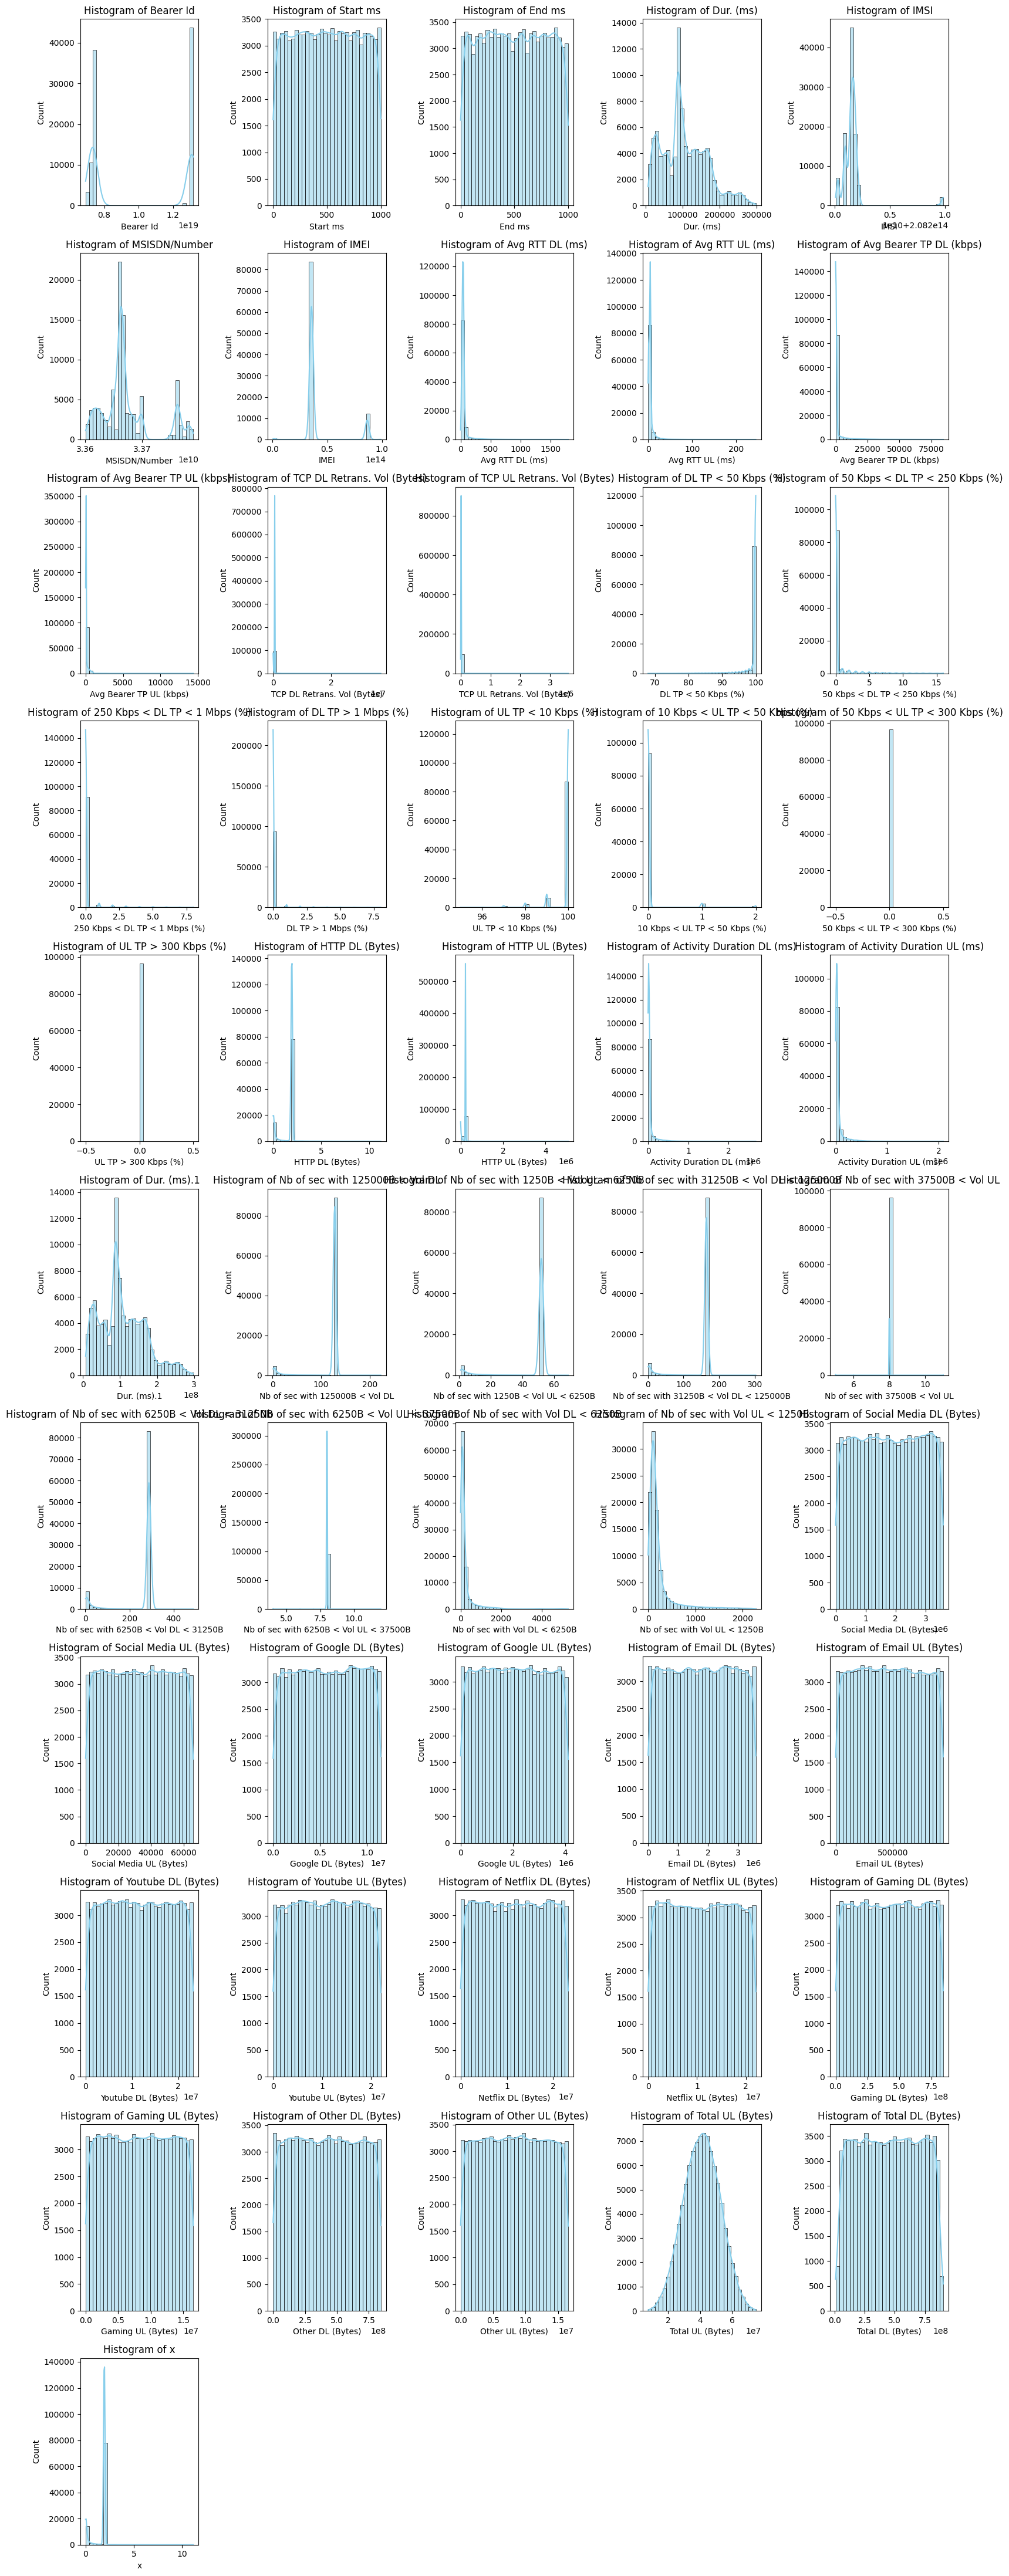

In [18]:
# Perform graphical univariate analysis using histograms to identify skewness
graphical_univariate_analysis(df)

### Bivariate Analysis (Relationship Between Applications and Total Data)

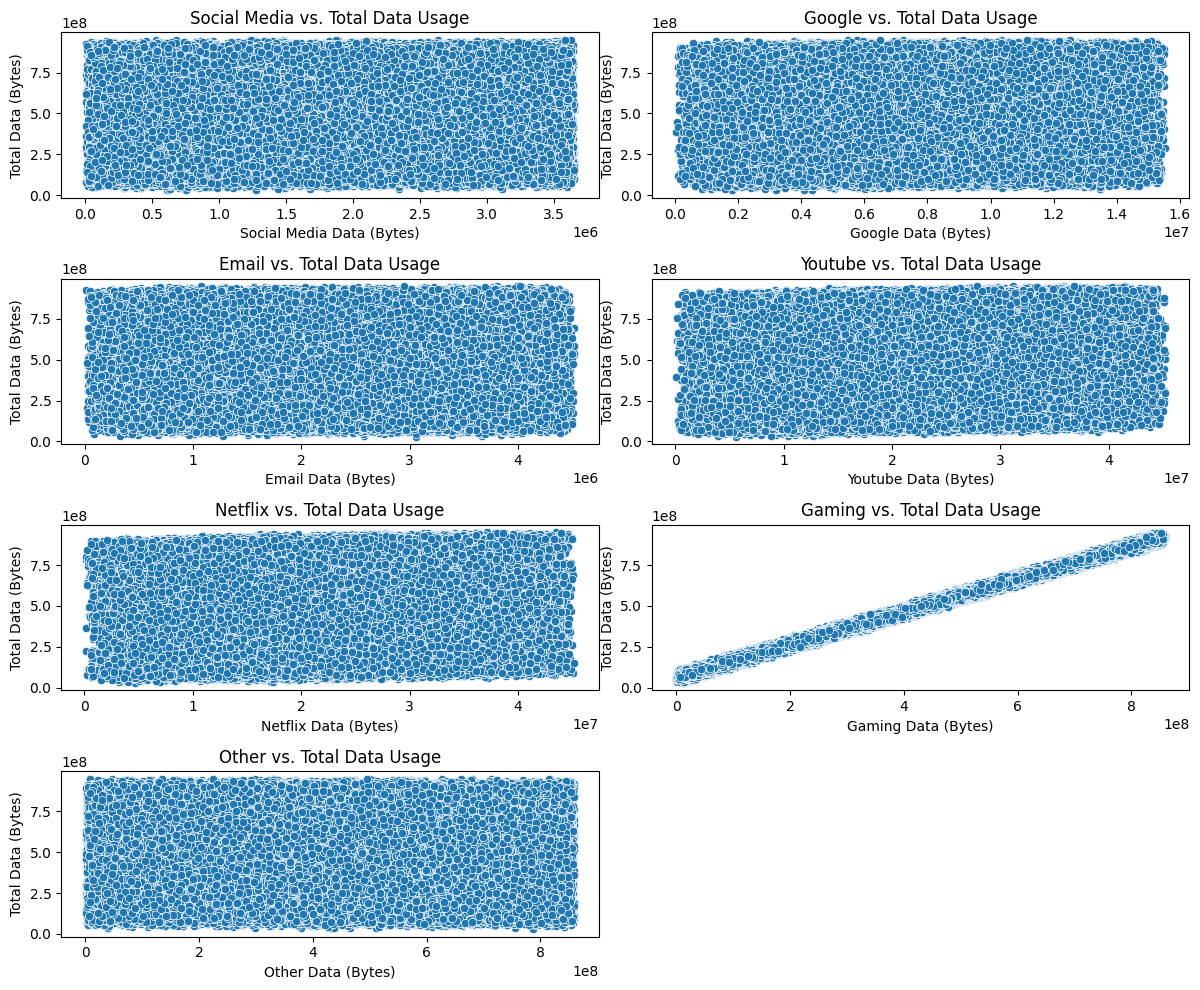

In [19]:
# Perform bivariate analysis by using scatter plots
bivariate_analysis(df)

### Correlation Analysis

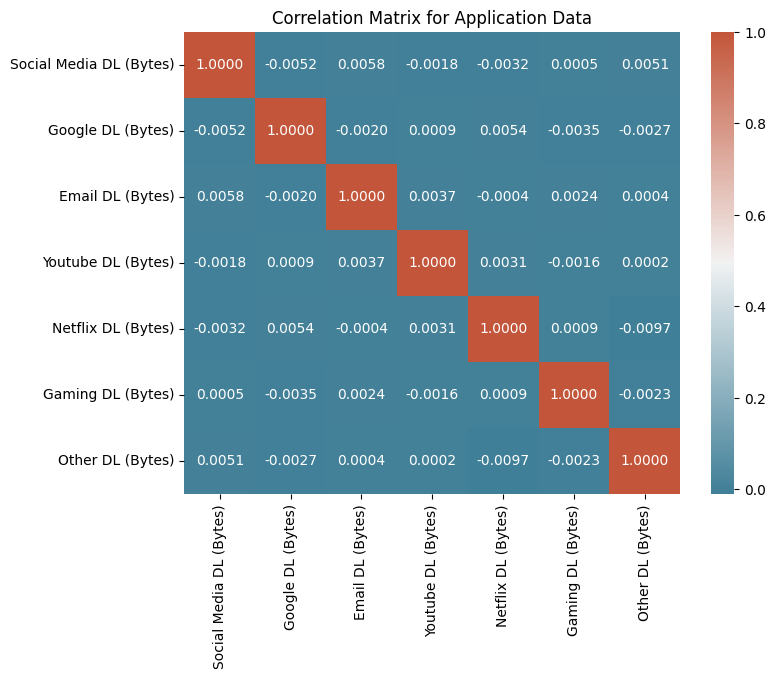

In [22]:
# Perform correlation analysis
correlation_analysis(df)


Values close to 1 indicate a strong positive correlation, while values close to -1 indicate a strong negative correlation. Most of the application Data have no correlation.

### Dimensionality Reduction (PCA)
Principal Component Analysis (PCA) can be used to reduce the number of dimensions while retaining as much variance as possible in the dataset.

By reducing to two components, we can visualize and interpret the data more easily, especially for clustering or predictive modeling.

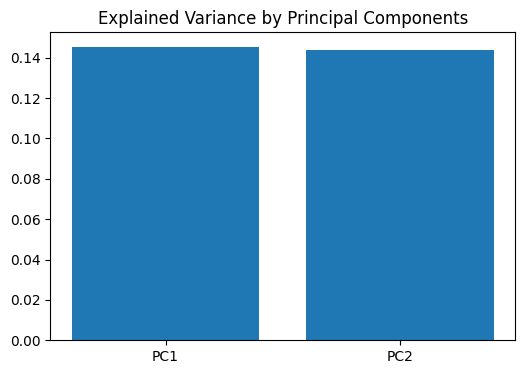

Explained Variance: [0.14530257 0.14376881]


In [21]:
# Perform PCA
pca_data, explained_variance = perform_pca(df)
print(f'Explained Variance: {explained_variance}')

Principal Component 1 (PC1) explains the variation in the data, likely related to total data consumption.
Principal Component 2 (PC2) captures secondary trends that are not explained by PC1.

The percentage of total variance explained by each principal component.